In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geomstats.backend as gs
import geomstats.visualization as visualization

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.matrices import Matrices, MatricesMetric

/Users/junhaozhu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/junhaozhu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO: Using numpy backend


In [2]:
time_names = pd.read_csv('time_names.csv', index_col=0)
time_names = time_names['time'].to_numpy()

time_names = time_names[time_names != 'D8.25']
time_names = time_names[time_names != 'D8.75']

# df = pd.read_csv(r'..\wot\data\full_df.csv')
df = pd.read_csv('ot_df.csv')
df = df[df['day'] != 8.25]
df = df[df['day'] != 8.75]
time_labels = [float(i[1:]) for i in time_names]
sample_size = pd.DataFrame()
sample_size['day'] = time_labels
sample_size['sample size'] = df.groupby('day').size().to_numpy()
T = len(time_labels)
k = len(np.unique(df['cell type']))


In [3]:
dfval= df[['x','y']].values

In [4]:
sample_size

,day,sample size
0,0.0,4732
1,0.5,3528
2,1.0,3822
3,1.5,2011
4,2.0,9898
5,2.5,7075
6,3.0,6971
7,3.5,8240
8,4.0,9160
9,4.5,7268


In [5]:
d= k-1 
from geomstats.geometry.hypersphere import Hypersphere

sphere = Hypersphere(dim=d) 
mfd= sphere.metric

In [6]:
type_list = df['cell type'].unique()
probs = []
for t in range(T):
    p_temp = df['cell type'][df['day'] == time_labels[t]].value_counts(normalize=True).reindex(type_list, fill_value=0).to_numpy()
    probs.append(p_temp)
probs = np.array(probs)

In [7]:
type_list

array(['MEF', 'MET', 'Stromal', 'Trophoblast', 'Neural', 'Epithelial',
       'IPS'], dtype=object)

In [8]:
data=np.sqrt(probs)
#data2=np.sqrt(probs2)

In [9]:
data_df = pd.DataFrame(data=data,index= np.arange(37),columns=type_list.tolist())


In [10]:
import seaborn as sns

In [9]:
#data_df_reset = data_df2.reset_index()

# Now, melt the DataFrame to long format
# 'Time' is the name of the former index column
# # 'CellType' will be the new column with cell types
# # 'Measurement' will be the column with the corresponding values
# long_df = data_df.melt(id_vars=['index'], var_name='CellType', value_name='Measurement')
# long_df = long_df.rename(columns={'index': 'Time'})

# # Create the plot
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=long_df, x='Time', y='Measurement', hue='CellType', palette='bright')

# # Adding labels and title (optional)
# plt.xlabel('Time')
# plt.ylabel('Measurement')
# plt.title('Curve Plot for Different Cell Types')

# # Show the plot
# plt.show()

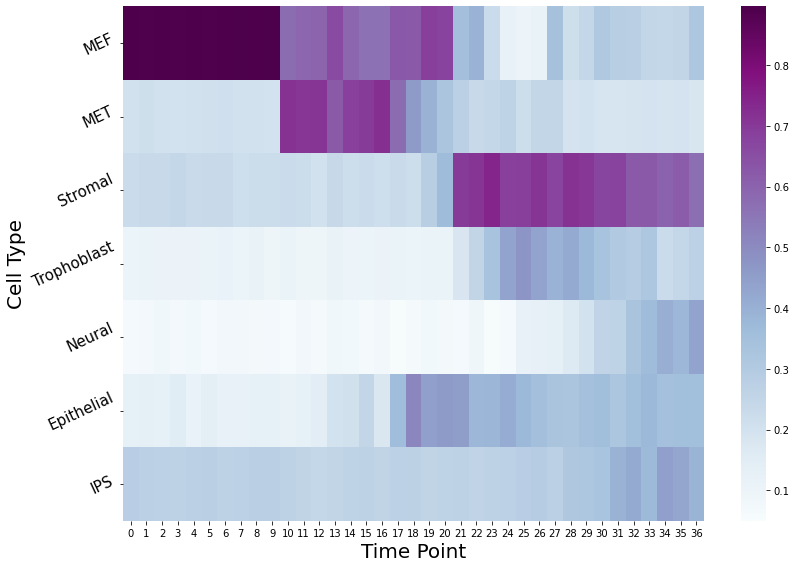

In [14]:
#data_df.style.background_gradient(cmap='Blues',)
fig, ax = plt.subplots(figsize=(12,8))
#sns.heatmap(data_df.T,cmap=sns.cubehelix_palette(as_cmap=True),ax=ax)
sns.heatmap(data_df.T,cmap='BuPu',ax=ax, vmin=0.05)
ax.set_xlabel("Time Point",fontsize=20)
ax.set_ylabel("Cell Type",fontsize=20)

#ax.xaxis.tick_top()

ax.set_yticklabels(labels=type_list.tolist(),fontsize=15,rotation=25)
plt.tight_layout()
plt.savefig('Cell_type_prop_SR.png',facecolor='w')

In [11]:
fmean = FrechetMean(metric=mfd,epsilon=0.0000001,max_iter=10000)
fmean.fit(data)
mean =fmean.estimate_
#mean

In [12]:
def resvec_to_sum(res_vec,w=3):
    # local sum 
    dim = res_vec.shape[1]
    N = res_vec.shape[0]
    res =np.zeros((N-w+1,dim))
    for i in range(dim):
        res[:,i] = np.convolve(res_vec[:,i], np.ones(w), 'valid')
    
    return res

def gamma_m(res_vec,w=3):
    localvar = resvec_to_sum(res_vec,w)**2
    n,dim = localvar.shape
    res = np.zeros((n,dim))
    for i in range(dim):
        res[:,i] = np.cumsum(localvar[:,i])/(w*n)
    return(res)


def volatity(res_vec,wlst):
    wm =max(wlst)
    L = len(wlst)
    n,dim = res_vec.shape
    localvar_res=np.zeros(shape=(n-wm+1 ,dim,L))
    for i in range(L):
         localvar_res[:,:,i] = gamma_m(res_vec,wlst[i])[:(n-wm+1),]
    
    vol = np.zeros((n-wm+1, dim,L-2))
    for j in range(n-wm+1):
        for k in range(dim):
            for i in range(L-2):
                vol[j,k,i] = np.std(localvar_res[j,k,i:(i+3)])
    
    vol_sum = np.sum(vol,axis=1)
    
    return np.max(vol_sum,axis=0)

def select_window(res_vec,wlst):
    vol = volatity(res_vec,wlst)
    idx = np.argmin(np.max(vol,axis=0))
    return(wlst[idx+1])
    

In [13]:
def local_sum(res,w=3):
    # local sum for reisduals
    dim = res.shape[1]
    N = res.shape[0]
    locsum =np.zeros((N-w+1,dim))
    for i in range(dim):
        locsum[:,i] = np.convolve(res[:,i], np.ones(w), 'valid')
    
    return locsum

def Hess(res,mu):
    theta= np.sqrt(mfd.inner_product(res,res,mu)) 
    u = res/theta
    ftheta=theta/np.sin(theta)
    u = np.reshape(u,(d+1,1))
    x = np.reshape(mu,(d+1,1))
    
    
    H = np.dot(u,np.transpose(u)) + ftheta*np.cos(theta)* (
        np.eye(7)-np.dot(u,np.transpose(u))-np.dot(x,np.transpose(x)))
    return(H)
    

def Hprocess(residual,mean):
    N = residual.shape[0]
    h = np.zeros((N,7,7))
    for i in range(N):
        h[i,:,:] = Hess(residual[i,:],mean)/N
    H = np.cumsum(h,axis=0)
    return(H)

def Hinv(y,mean,H):
    l,v= np.linalg.eig(H)
    lidx = [0,1,2,3,4,5,6]
    lidx.remove(np.argmin(np.abs(l)))
    l = l[lidx]
    v = v[:,lidx]
    invvec = np.zeros(7)
    #invvec
    for k in range(6):
        invvec = mfd.inner_product(y,v[:,k])*v[:,k]/l[k] + invvec
        #mfd.inner_product(y,v[:,1])*v[:,1]/l[1]+mfd.inner_product(y,v[:,0])*v[:,0]/l[0]
    return(invvec)


def generate_Phi(locsum):
    #Philst = np.zeros(locsum.shape)
    n = locsum.shape[0]
    g = np.random.normal(size=n)
    g = g.reshape((n,1))
    dPhi = g*locsum
    Phi = np.cumsum(dPhi,axis=0)
    return Phi



def bootstrap_test(residual, mean, w=24 ,B=400,seed=2023):
    n =residual.shape[0]
    res_cusum =np.cumsum(residual,axis=0)
    Ht = Hprocess(residual,mean)
    res_cusum_norm = np.sqrt(mfd.inner_product(res_cusum,res_cusum,mean))

    Tn = res_cusum_norm.max()/np.sqrt(n)
    
    B =B# bootstrap size 
    Boot_Stat= np.zeros(B)  
    Boot_Stat2 = np.zeros(B)  
    locsum = local_sum(residual,w=w)
    
    for i in range(B):
        np.random.seed(seed*2023+i)
        Phi = generate_Phi(locsum)/np.sqrt(w*(n-w+1))
        
        HinvPhi = Hinv(Phi[n-w],mean,Ht[n-w])
        
        for k in range(n-w+1):
            Phi[k] = Phi[k]-np.dot(Ht[k],HinvPhi)
           
        
        Phinorm = np.sqrt(mfd.inner_product(Phi,Phi,mean))
        
        Boot_Stat[i] = np.max(Phinorm[w:])
     
        
    
    for i in range(B):
        np.random.seed(seed*2023+i)
        Phi = generate_Phi(locsum)/np.sqrt(w*(n-w+1))
        for k in range(n-w+1):
            Phi[k] = Phi[k]-(k+1)/(n-w+1)*Phi[n-w]
        
        Phinorm = np.sqrt(mfd.inner_product(Phi,Phi,mean))
        Boot_Stat2[i] = np.max(Phinorm[w:])
        
    return np.mean(Boot_Stat>=Tn),np.mean(Boot_Stat2>=Tn)

In [14]:
#windows = np.linspace(0.1, 0.1, num=10)*nsamples 
#windows= (np.rint(windows)).astype(int)# window size candidate
B =2000    
windows=   np.array([1,2,3,4,5])
#fmean = FrechetMean(metric=mfd,max_iter=400)
fmean = FrechetMean(metric=mfd,epsilon=0.0000001,max_iter=100000)
fmean.fit(data)
mean =fmean.estimate_
residual = mfd.log(point=data,base_point=mean) # residual
 
w1 = select_window(residual,windows) # selec window size in bootstrap
#Wselect1[m] = w1
    
pval,pval2 = bootstrap_test(residual, mean, w= w1,B=B,seed=666)

In [15]:
pval,pval2 #pvalue for Curvature Adjusted Multiplier Bootstrap (CAMB) and B1 

(0.0005, 0.0005)

In [16]:
def bootstrap_test_Eu(residual, mean, w=24 ,B=400,seed=2023):
    n =residual.shape[0]
    res_cusum =np.cumsum(residual,axis=0)
   # Ht = Hprocess(residual,mean)
    #res_cusum_norm = np.sqrt(mfd.inner_product(res_cusum,res_cusum,mean))
    res_cusum_norm = np.sqrt(np.sum(res_cusum*res_cusum,axis=1))
    Tn = res_cusum_norm.max()/np.sqrt(n)
    
    B =B# bootstrap size 
    Boot_Stat= np.zeros(B)  
    #Boot_Stat2 = np.zeros(B)  
    locsum = local_sum(residual,w=w)
    
#     for i in range(B):
#         np.random.seed(seed*2023+i)
#         Phi = generate_Phi(locsum)/np.sqrt(w*(n-w+1))
        
#         HinvPhi = Hinv(Phi[n-w],mean,Ht[n-w])
        
#         for k in range(n-w+1):
#             Phi[k] = Phi[k]-np.dot(Ht[k],HinvPhi)
           
        
#         Phinorm = np.sqrt(mfd.inner_product(Phi,Phi,mean))
        
#         Boot_Stat[i] = np.max(Phinorm[w:])
     
        
    
    for i in range(B):
        np.random.seed(seed*2025+i)
        Phi = generate_Phi(locsum)/np.sqrt(w*(n-w+1))
        for k in range(n-w+1):
            Phi[k] = Phi[k]-(k+1)/(n-w+1)*Phi[n-w]
        
        Phinorm = np.sqrt(np.sum(Phi*Phi,axis=1))
        Boot_Stat[i] = np.max(Phinorm[w:])
        
    return np.mean(Boot_Stat>=Tn)

residual_eu = probs-np.mean(probs ,axis=0)
pval3 = bootstrap_test_Eu(residual_eu, mean, w= w1,B=B,seed=666)

In [17]:
pval3

0.0

In [18]:
def clr_transform(x):
    """
    Apply the Aitchison (CLR) transformation to a compositional vector x.

    Parameters:
    x (array-like): Compositional vector (positive entries summing to 1)

    Returns:
    np.ndarray: CLR-transformed vector
    """
    x = np.asarray(x)
    if np.any(x <= 0):
        raise ValueError("All components must be positive.")
    log_x = np.log(x)
    mean_log = np.mean(log_x)
    return log_x - mean_log

In [21]:
Ait_data= np.zeros((probs.shape))
for i in range(Ait_data.shape[0]):
    Ait_data[i] = clr_transform(probs[i])

In [23]:
residual_ait = Ait_data-np.mean(Ait_data ,axis=0)
pval3 = bootstrap_test_Eu(Ait_data, 0, w= w1,B=B,seed=666)

In [24]:
pval3 # ait geometry

0.0